In [1]:
from pylab import *

from mpl_toolkits.mplot3d import axes3d, Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import transforms3d
import numpy as np
import os



In [2]:
NUM_SAMPLES = 1
NUM_POINTS = 1500
F = 550
B = 70

array([[   4.58534276,  -24.78146783,   76.14417489],
       [ -24.78146783,  159.84591065, -486.77883235],
       [  76.14417489, -486.77883235, 1495.68914969]])

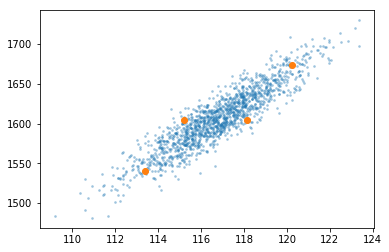

In [8]:
def get_plane_eq(p1,p2,p3):
    #p1 = np.array(p1)
    #p2 = np.array(p2)
    #p3 = np.array(p3)

    v1 = p3 - p1
    v2 = p2 - p1
    cp = np.cross(v1, v2)
    a, b, c = cp/np.linalg.norm(cp)

    # This evaluates a * x3 + b * y3 + c * z3 which equals d
    d = np.dot(cp, p3)
    return np.array([a,b,c,d])
for s in range(NUM_SAMPLES):
    x,y = np.random.randint(-320,320), np.random.randint(-240,240) 
    d = np.random.randint(2,64)
    #x,y,d = 1,0,3
    z = (F*B)/d
    ogpt = (z*x/F,z*y/F,z)
    
    zf = (F*B)/(d+1)
    zb = (F*B)/(d-1)
    

    frtpt = (zf*(x+0.5)/F,zf*y/F,zf)
    lftpt = (z*(x-0.5)/F,z*y/F,z)
    rgtpt = (z*(x+0.5)/F,z*y/F,z)
    bckpt = (zb*(x-0.5)/F,zb*y/F,zb)
    
    frtptT = np.array(((x+0.5)/F,(y+0.5)/F,1))*zf
    lftptT = np.array(((x-0.5)/F,(y+0.5)/F,1))*z
    rgtptT = np.array(((x+0.5)/F,(y+0.5)/F,1))*z
    bckptT = np.array(((x-0.5)/F,(y+0.5)/F,1))*zb
    
    frtptB = np.array(((x+0.5)/F,(y-0.5)/F,1))*zf
    lftptB = np.array(((x-0.5)/F,(y-0.5)/F,1))*z
    rgtptB = np.array(((x+0.5)/F,(y-0.5)/F,1))*z
    bckptB = np.array(((x-0.5)/F,(y-0.5)/F,1))*zb
    
    box = np.vstack([frtptT,lftptT,rgtptT,bckptT,frtptB,lftptB,rgtptB,bckptB])
    min_bounds = box.min(0)
    max_bounds = box.max(0)
    
    # facing plane, clockwise winding order
    A = get_plane_eq(frtptT,lftptT,rgtptT)
    Z = get_plane_eq(frtptB,rgtptB,lftptB)

    C = get_plane_eq(frtptT,rgtptT,rgtptB)
    Y = get_plane_eq(bckptT,lftptT,lftptB)
    
    E = get_plane_eq(lftptT,frtptT,frtptB)
    X = get_plane_eq(rgtptT,bckptT,bckptB)
    
    the_planes = np.vstack([A,Z,C,Y,E,X])
    
    span = max_bounds - min_bounds
    dim_probs = span/np.linalg.norm(span)
    pts = []
    #while len(pts) < NUM_POINTS:
    rpts = np.random.rand(NUM_POINTS,3)*span + min_bounds
    dv = np.vstack([frtptB,lftptB,bckptB,rgtptB])

    covar = np.zeros((3,3))
    m = box.mean(0,keepdims=1)
    M = m.T @ m
    for pt in box:
        pt = pt.reshape((-1,1))
        covar += (pt @ pt.T - M)
    covar = covar/12
    funny_covar = np.copy(covar)
    
    
    gpts = np.random.multivariate_normal(m.ravel(),covar,NUM_POINTS)
    plt.figure()
    plt.scatter(gpts[:,0],gpts[:,2],s=3,alpha=0.3)
    plt.scatter(dv[:,0],dv[:,2])
funny_covar

[0.  2.8 0. ]
AREA
98.381221802544
98.381221802544
[[  11.3675463   -45.35222222  139.74074074]
 [ -45.35222222  289.12041667 -890.84722222]
 [ 139.74074074 -890.84722222 2744.90740741]]
[[ 4.08775371e-08 -1.81678152e-07  5.59792627e-07]
 [-1.81678152e-07  8.07487573e-07 -2.48805695e-06]
 [ 5.59792627e-07 -2.48805695e-06  7.66628191e-06]]
[[ 4.77243637e-09 -2.12110067e-08  6.53560431e-08]
 [-2.12110067e-08  9.42719339e-08 -2.90473746e-07]
 [ 6.53560431e-08 -2.90473746e-07  8.95017145e-07]]
[[ 3.61051007e-08 -1.60467146e-07  4.94436584e-07]
 [-1.60467146e-07  7.13215639e-07 -2.19758320e-06]
 [ 4.94436584e-07 -2.19758320e-06  6.77126477e-06]]
[[  11.3675463   -45.35222222  139.74074074]
 [ -45.35222222  289.12041667 -890.84722222]
 [ 139.74074074 -890.84722222 2744.90740741]]
next
[   0.         -187.15277778  -60.73958333]
next
[   0.         -203.42693237  -66.02128623]
next
[  0.         187.15277778  61.07986111]
next
[  0.         203.42693237  66.39115338]
next
[-187.15277778    0.

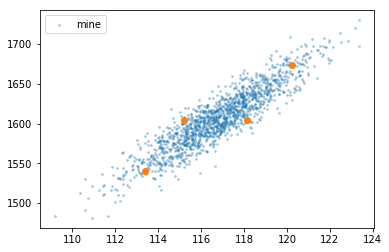

In [56]:
print(frtptT-frtptB)
X,Y,Z = frtptT,lftptT,rgtptT
np.linalg.norm(np.cross(X-Y,Z-Y))/2

M = 1/3 * (X+Y+Z)
c1 = X[:,None] @ X[None,:] + Y[:,None] @ Y[None,:] +  Z[:,None] @ Z[None,:] - 3 * M[:,None] @ M[None,:]

A = np.vstack([X,Y,Z]).T
c2 =A @ np.array([[2,1,1],[1,2,1],[1,1,2] ])/120 @ A.T
c2 = c2 * np.linalg.det(A) #* (c1[0,0]/c2[0,0])
center = 1/4 * (X+Y+Z)
mass = np.linalg.det(A/6)
total_center = center
correct = np.array(tuple(tuple(x * y  for x in total_center) for y in total_center))*mass
correct
c3 = c2 - correct

AB = X-Z
AC = Y-Z
print('AREA')
print(np.linalg.norm(np.cross(AB,AC))/2)
print(np.linalg.norm(np.cross(X-Y,Z-Y))/2)

Mt = np.array([[2,1,1], [1,2,1], [1,1,2] ])
v = np.zeros(3)
A = np.vstack([X-M,Y-M,Z-M]).T
c4 = A @ Mt @ A.T
print(c1)
print(c2)
print(correct)
print(c3)
print(c4)
frtptT,lftptT,rgtptT,bckptT
frtptB,lftptB,rgtptB,bckptB

tris = []
#cw triangles
# top
f1t1 = [lftptT,rgtptT,frtptT]
f1t2 = [lftptT,bckptT,rgtptT]
#bottom
f2t1 = [rgtptB,lftptB,frtptB]
f2t2 = [rgtptB,bckptB,lftptB]

#front right
f3t1 = [frtptT,rgtptT,rgtptB]
f3t2 = [rgtptB,frtptB,frtptT]

#front left
f4t1 = [frtptT,frtptB,lftptB]
f4t2 = [lftptB,lftptT,frtptT]

#back right
f5t1 = [rgtptT,bckptT,bckptB]
f5t2 = [bckptB,rgtptB,rgtptT]

#back right
f6t1 = [bckptT,lftptT,lftptB]
f6t2 = [lftptB,bckptB,bckptT]
verts = [f1t1,f1t2,f2t1,f2t2,f3t1,f3t2,f4t1,f4t2,f5t1,f5t2,f6t1,f6t2]
canon = np.array([[2,1,1],[1,2,1],[1,1,2]])/120.0

for t in verts:
    print('next')
    print(np.cross(t[2]-t[0],t[1]-t[0]))
tris = verts

#def get_com_cvar(tris):
coms = []
masses = []
covars = []


for t in tris:
    A = np.array([t[0],t[1],t[2]]).T
    det = np.linalg.det(A)
    C = det * A @ canon @ A.T
    mass = det/6
    com = (np.sum(t,0))/4

    coms.append(com)
    covars.append(C)
    masses.append(mass)
total_covar = np.zeros((3,3))
total_com = np.zeros(3)
total_mass = sum(masses)
for com, mass in zip(coms,masses):
    total_com += (mass/total_mass) * com
total_covar = np.array(covars).sum(0) - total_mass * (total_com[:,None] @ total_com[None,:])
#return total_covar, total_com, total_mass

clast = np.zeros((3,3))

for t,m,cm in zip(tris,masses,coms):
    A = np.array([t[0]-total_com,t[1]-total_com,t[2]-total_com]).T
    clast += np.linalg.det(A) * A @ canon @ A.T #- (1/total_mass)*(m*cm[:,None]) @ (m*cm[None,:])

#final_covar,final_com,final_mass = get_com_cvar(verts)

if False:
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = Axes3D(fig)
    b2 = np.array(verts)
    minb = b2.reshape((-1,3)).min(0)
    maxb = b2.reshape((-1,3)).max(0)
    meanb = b2.reshape((-1,3)).mean(0)
    span = maxb-minb
    w = span/2
    pc = Poly3DCollection(verts, alpha = 0.2, facecolor='b', linewidths=1,edgecolors='r')
    ax.add_collection3d(pc)
    ax.set_xlim(minb[0]-w[0],maxb[0]+w[0])
    ax.set_ylim(minb[1]-w[1],maxb[1]+w[1])
    ax.set_zlim(minb[2]-w[2],maxb[2]+w[2])

    plt.show()
gpts2 = np.random.multivariate_normal(total_com,total_covar,NUM_POINTS)
plt.figure()
#plt.scatter(gpts2[:,0],gpts2[:,2],s=3,alpha=0.3,label='form/12')
plt.scatter(gpts[:,0],gpts[:,2],s=3,alpha=0.3,label='mine')
plt.legend()
plt.scatter(dv[:,0],dv[:,2])
funny_covar = np.zeros_like(funny_covar)
m = total_com[None,:]
M = m.T @ m
for pt in box:
    pt = pt.reshape((-1,1))
    funny_covar += (pt @ pt.T - M)
funny_covar = funny_covar/12

In [57]:
total_covar, total_com, total_mass, clast

(array([[   1307.44291414,   -7066.70227837,   21713.33102325],
        [  -7066.70227837,   45581.96973494, -138810.22332835],
        [  21713.33102325, -138810.22332859,  426511.85939097]]),
 array([ 116.78505157, -522.8401511 , 1606.49208437]),
 570.2558111040323,
 array([[   1307.44291423,   -7066.70227884,   21713.33102436],
        [  -7066.70227884,   45581.9697373 , -138810.22333432],
        [  21713.33102436, -138810.22333432,  426511.85940713]]))

In [58]:
print(np.linalg.norm(np.cross(X-Y,Z-Y))/2)

temp = np.array([X,Y,Z])
temp,np.linalg.det(temp)


98.381221802544


(array([[ 113.4       , -499.8       , 1540.        ],
        [ 115.20833333, -520.625     , 1604.16666667],
        [ 118.125     , -520.625     , 1604.16666667]]), 1.022834163045952e-10)

In [59]:
funny_covar,m,(total_covar/funny_covar),((2*clast/total_mass)/funny_covar)

(array([[  -2.78936875,   15.29792338,  -47.00479252],
        [  15.29792338,  -51.20343371,  161.69680675],
        [ -47.00479252,  161.69680675, -496.83376374]]),
 array([[ 116.78505157, -522.8401511 , 1606.49208437]]),
 array([[-468.72358229, -461.93866322, -461.93866323],
        [-461.93866322, -890.2131446 , -858.45989245],
        [-461.93866323, -858.45989245, -858.45989246]]),
 array([[-1.64390638, -1.62011032, -1.62011032],
        [-1.62011032, -3.1221537 , -3.01078876],
        [-1.62011032, -3.01078876, -3.01078876]]))

In [358]:
pt_planes = np.hstack([rpts,np.ones((NUM_POINTS,1)) ]) @ the_planes.T
valid_pts = (pt_planes <= 0).sum(1)
print((valid_pts == 6).sum())
print((valid_pts == 0).sum())
print((pt_planes <= 0).sum(0))
pts = rpts[(valid_pts <=1)]
print(len(pts))

0
0
[ 631  631  671  706    0 1500]
22


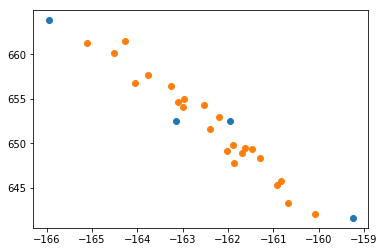

In [9]:
%matplotlib inline
plt.scatter(dv[:,0],dv[:,2])
plt.scatter(pts[:,0],pts[:,2])


<IPython.core.display.Javascript object>


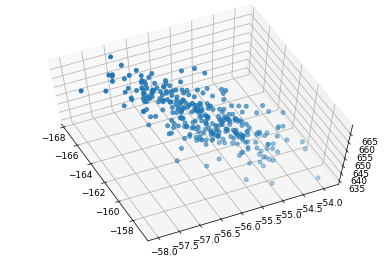

[[(-159.24999999999997, -55.416666666666664, 641.6666666666666), (-163.135593220339, -56.355932203389834, 652.542372881356), (-165.94827586206895, -57.32758620689655, 663.7931034482758), (-161.94915254237287, -56.355932203389834, 652.542372881356)]]
[ 6.69827586  3.07758621 22.12643678]


In [11]:
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
x = [0, 1, 1, 0]
y = [0, 0, 1, 1]
z = [0, 1, 0, 1]
verts2 = [list(zip(x, y, z))]
verts = [[tuple(_) for _ in dv]]
print(verts)
ax.scatter3D(gpts[:,0],gpts[:,1],gpts[:,2])
plt.show()
print(span)

In [9]:
verts

[[(982.6923076923077, -1257.3076923076924, 2961.5384615384614),
  (1058.75, -1362.0833333333335, 3208.3333333333335),
  (1155.0, -1485.909090909091, 3500.0),
  (1064.5833333333335, -1362.0833333333335, 3208.3333333333335)]]

In [10]:
list([tuple(_) for _ in dv])

[(982.6923076923077, -1257.3076923076924, 2961.5384615384614),
 (1058.75, -1362.0833333333335, 3208.3333333333335),
 (1155.0, -1485.909090909091, 3500.0),
 (1064.5833333333335, -1362.0833333333335, 3208.3333333333335)]